# Clustering using PaCMAP
PaCMAP repo: https://github.com/YingfanWang/PaCMAP

Clusters are colored by reagion

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/12 16:00:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/12 16:00:53 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/04/12 16:00:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### embeddings

In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Sat Apr 12 04:00:57 PM EDT 2025


### test embeddings

In [4]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/embeddings"

# Define the path to the train and test parquet files
test_path = f"{data_path}/test_2025/test_2025_grid=1x1"

# Read the parquet files into a spark DataFrame
test_df = spark.read.parquet(test_path)

# Show the data
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- tile: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)



+--------------------+----+--------------------+---------+
|          image_name|tile|       cls_embedding|sample_id|
+--------------------+----+--------------------+---------+
|CBN-Pla-B3-201907...|   0|[0.48756203, 1.03...|        0|
|CBN-PdlC-C4-20190...|   0|[-0.0045433897, 1...|        0|
|CBN-Pla-C6-201809...|   0|[0.45772696, 1.60...|        0|
|CBN-Pla-C4-201607...|   0|[-0.26255822, 1.4...|        0|
|CBN-Pla-F5-201308...|   0|[0.8492722, 1.802...|        0|
+--------------------+----+--------------------+---------+
only showing top 5 rows



In [5]:
# count number of rows: should be 2105 for grid=1x1
print(f"Number of rows: {test_df.count()}")

Number of rows: 2105


In [6]:
regions = [
    "2024-CEV3",
    "CBN-can",
    "CBN-PdlC",
    "CBN-Pla",
    "CBN-Pyr",
    "GUARDEN-AMB",
    "GUARDEN-CBNMed",
    "LISAH-BOU",
    "LISAH-BVD",
    "LISAH-JAS",
    "LISAH-PEC",
    "OPTMix",
    "RNNB",
]

len(regions)

13

In [7]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, regexp_extract


def prepare_emb_df(df: DataFrame, emb_col: str):
    """
    Prepare the DataFrame by renaming the embedding column and selecting relevant columns.
    """
    regex_pattern = "|".join([f"^{region}" for region in regions])
    # add the grouped_regions column using regexp_extract
    test_df_with_regions = test_df.withColumn(
        "grouped_regions", regexp_extract(col("image_name"), f"({regex_pattern})", 1)
    )

    # check if there are any unmatched regions (empty strings)
    unmatched_count = test_df_with_regions.filter(col("grouped_regions") == "").count()
    print(f"Number of rows with unmatched regions: {unmatched_count}")

    # show the result with the new column
    test_df_with_regions.select("image_name", "grouped_regions", "cls_embedding").show(
        10, truncate=True
    )

    # Count occurrences of each region
    region_counts = (
        test_df_with_regions.groupBy("grouped_regions")
        .count()
        .orderBy(col("count").desc())
    )
    region_counts.show(20)
    return test_df_with_regions


test_df_with_regions = prepare_emb_df(test_df, "cls_embedding")

Number of rows with unmatched regions: 0
+--------------------+---------------+--------------------+
|          image_name|grouped_regions|       cls_embedding|
+--------------------+---------------+--------------------+
|CBN-Pla-B3-201907...|        CBN-Pla|[0.48756203, 1.03...|
|CBN-PdlC-C4-20190...|       CBN-PdlC|[-0.0045433897, 1...|
|CBN-Pla-C6-201809...|        CBN-Pla|[0.45772696, 1.60...|
|CBN-Pla-C4-201607...|        CBN-Pla|[-0.26255822, 1.4...|
|CBN-Pla-F5-201308...|        CBN-Pla|[0.8492722, 1.802...|
|CBN-Pla-B6-201908...|        CBN-Pla|[-0.0071166656, 1...|
|RNNB-6-10-2024011...|           RNNB|[0.44274005, 0.52...|
|CBN-PdlC-D1-20180...|       CBN-PdlC|[0.59654564, 1.54...|
|CBN-PdlC-D5-20200...|       CBN-PdlC|[0.39087006, 1.40...|
|CBN-PdlC-A2-20180...|       CBN-PdlC|[-1.585177, 2.103...|
+--------------------+---------------+--------------------+
only showing top 10 rows

+---------------+-----+
|grouped_regions|count|
+---------------+-----+
|       CBN-PdlC|  81

In [8]:
test_df_with_regions.count()

2105

In [11]:
import pacmap
import numpy as np
from sklearn.preprocessing import StandardScaler


def get_pandas_embeddings(df: DataFrame, col_name: str):
    # Convert to Pandas DF
    pandas_df = df.select([col_name, "grouped_regions"]).toPandas()

    # Extract features and labels
    emb_df = np.stack(pandas_df[col_name].values)
    scaled_emb = StandardScaler().fit_transform(emb_df)

    # PaCMAP reduction
    reducer = pacmap.PaCMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(
        scaled_emb
    )  # NumPy array with shape (n_samples, 2)
    return pandas_df, embedding, scaled_emb

In [12]:
# embeddings
pandas_df, cls_embedding, cls_scaled_emb = get_pandas_embeddings(
    df=test_df_with_regions, col_name="cls_embedding"
)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rc("font", size=14)  # controls default text size


def plot_pacmap_clusters(
    pandas_df: pd.DataFrame,
    cls_embedding: pd.DataFrame,
    figsize: tuple = (8, 6),
    dpi: int = 120,
):
    # Plot the data
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=dpi)
    fig.suptitle(
        "PaCMAP projection of quadrats by region",
        fontsize=22,
        weight="bold",
    )

    # Create a scatter plot, color-coded by region
    top_regions_idx = pandas_df["grouped_regions"].value_counts().nlargest(13).index

    # Use a colormap with distinct colors
    colors = plt.cm.tab10.colors

    # Iterate directly through the index
    for i, region in enumerate(top_regions_idx):
        # Select embeddings for the current region
        idx = pandas_df["grouped_regions"] == region
        ax.scatter(
            cls_embedding[idx, 0],
            cls_embedding[idx, 1],
            label=region,
            s=20,
            alpha=0.7,
            linewidth=0.5,
            color=colors[i % len(colors)],  # Use modulo to cycle through colors
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)

    # Remove spines
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)

    fig.tight_layout(pad=0.8)

    # Create legend
    lgnd = plt.legend(
        ncol=3,
        loc="lower right",
        fontsize=12,
        bbox_to_anchor=(0.95, -0.35),
        shadow=True,
    )

    # Adjust legend marker sizes
    for handle in lgnd.legend_handles:
        handle.set_sizes([60.0])
    # path = Path(os.getcwd()).parents[1]
    # plt.savefig(f"{path}/figures/umap_cluster.png", bbox_inches="tight")
    plt.show()

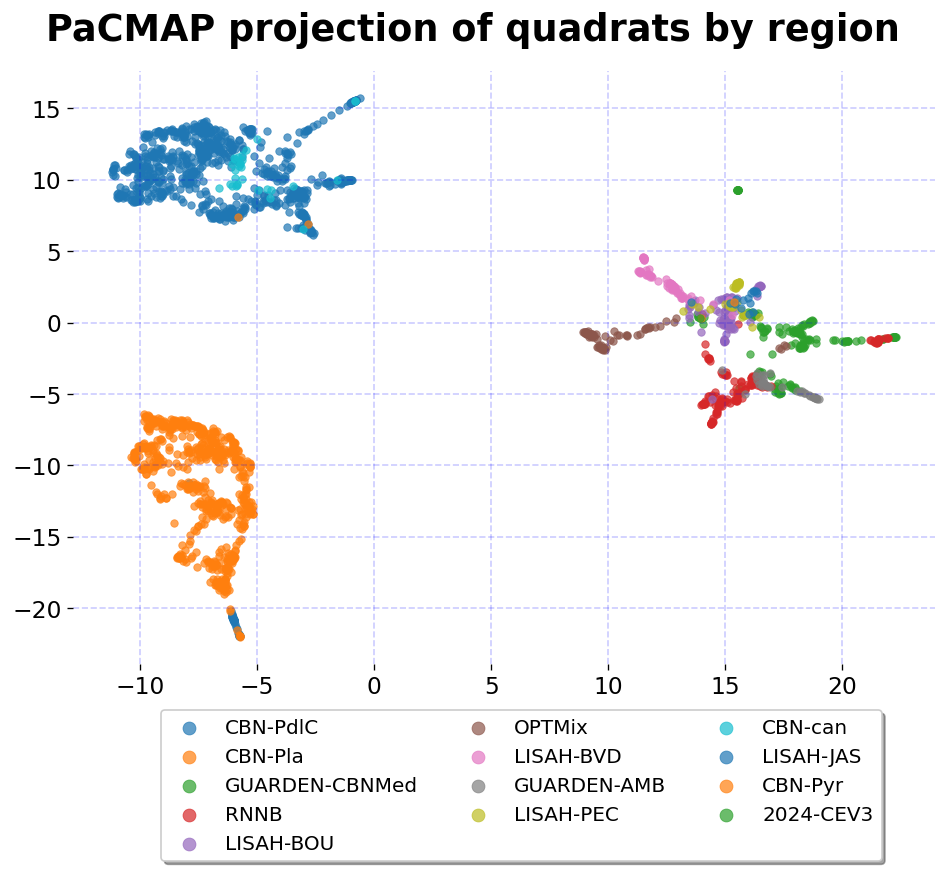

In [38]:
# plot PaCMAP clusters
plot_pacmap_clusters(
    pandas_df,
    cls_embedding,
    figsize=(8, 6),
    dpi=120,
)

In [ ]:
# TODO:
# run KMeans clustering on the PaCMAP embeddings
# group by cluster identities